# All Python packages

In [ ]:
!pip3 install numpy
!pip3 install sklearn
!pip3 install scipy
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install keras
!pip3 install mne

In [1]:
from IPython.utils import io
import numpy as np
import collections

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

import scipy.io
from scipy import signal, integrate
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout

import mne
import eeg_entropy
import math

n_second = 60
n_segment = 2*n_second-1
n_points = n_second*128
bottleneck = 12

# MinMaxScaler() and (a - min_) / (max_ - min_)

In [2]:
# build in
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
scaler = MinMaxScaler().fit(a)
a = scaler.transform(a)
print(a)

#custom
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
max_, min_ = np.amax(a), np.amin(a)
a = (a - min_) / (max_ - min_)
print(a)

def normalise_2D(a, multiple):
    max_, min_ = np.amax(a), np.amin(a)
    a = (a - min_) / (max_ - min_)
    return multiple*a

a = np.array([[1,2,3],[4,5,6],[7,8,9]])
normalise_2D(a, 1) # range -10 to 10

[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]
[[0.    0.125 0.25 ]
 [0.375 0.5   0.625]
 [0.75  0.875 1.   ]]


array([[0.   , 0.125, 0.25 ],
       [0.375, 0.5  , 0.625],
       [0.75 , 0.875, 1.   ]])

# StandardScaler() and (a-mean)/std

In [3]:
# build in
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
scaler = StandardScaler().fit(a)
a = scaler.transform(a)
print(a)

# custom
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
std = np.std(a)
mean = np.mean(a)
a = (a-mean)/std
print(a)

def standardise_2D(a, multiple):
    std = np.std(a)
    mean = np.mean(a)
    a = (a-mean)/std
    return multiple*a

a = np.array([[1,2,3],[4,5,6],[7,8,9]])
standardise_2D(a, 10)

[[-1.22474487 -1.22474487 -1.22474487]
 [ 0.          0.          0.        ]
 [ 1.22474487  1.22474487  1.22474487]]
[[-1.54919334 -1.161895   -0.77459667]
 [-0.38729833  0.          0.38729833]
 [ 0.77459667  1.161895    1.54919334]]


array([[-15.49193338, -11.61895004,  -7.74596669],
       [ -3.87298335,   0.        ,   3.87298335],
       [  7.74596669,  11.61895004,  15.49193338]])

# Convert DEAP dataset from matlab to numpy

In [4]:
def convertOneData(file_name):
    mat = scipy.io.loadmat(file_name)
    labels = mat['labels'][:, 0:2] # only valence, arousal, no dominance, liking
    data = mat['data'][:, 0:32, 3*128:] # only first 32 channels ['Fp1','AF3','F3','F7','FC5',
    #'FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4',
    #'F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
    #and skip first 3 seconds
    #print(labels.shape, data.shape) # (40, 2) (40, 32, 8064)
    valence_labels, valence_data = [], []
    arousal_labels, arousal_data = [], []
    for i, label in enumerate(labels):
        valence, arousal = label[0], label[1]
        if valence > 5.5: # value >5.5 is high
            valence_labels.append(1)
            valence_data.append(data[i])
        if valence < 4.5: # value <4.5 is high
            valence_labels.append(0)
            valence_data.append(data[i])
        if arousal > 5.5:
            arousal_labels.append(1)
            arousal_data.append(data[i])
        if arousal < 4.5:
            arousal_labels.append(0)
            arousal_data.append(data[i])
    
    print("valence: ", len(valence_labels), "arousal: ", len(arousal_labels))
    return valence_labels, valence_data, arousal_labels, arousal_data        
    

def convertAllData():
    all_valence_labels, all_valence_data = [], []
    all_arousal_labels, all_arousal_data = [], []
    for i in range(32): 
        if i < 10: # subject 01-09
            name = '%0*d' % (2,i+1)
        else: # subject 10-32
            name = i+1
        file_name = "../Data/DEAP/s"+str(name)+".mat"
        print(file_name)
        valence_labels, valence_data, arousal_labels, arousal_data = convertOneData(file_name) # convert one subject data
        
        all_valence_labels += valence_labels
        for valence_d in valence_data: # each trial
            valence_d = standardise_2D(valence_d, 1)
            all_valence_data.append(valence_d)    
        all_arousal_labels += arousal_labels
        for arousal_d in arousal_data:
            arousal_d = standardise_2D(arousal_d, 1)
            all_arousal_data.append(arousal_d)
     
    all_valence_labels = np.array(all_valence_labels)
    all_valence_data = np.array(all_valence_data)
    all_arousal_labels = np.array(all_arousal_labels)
    all_arousal_data = np.array(all_arousal_data)
    print("Valence trial data for all subject: ", all_valence_labels.shape,all_valence_data.shape)
    print("Arousal trial data for all subject: ", all_arousal_labels.shape,all_arousal_data.shape)
    # save numpy array of total data to files
    np.save('../Data/processed_DEAP/valence/' + 'all_valence_labels.npy', all_valence_labels)
    np.save('../Data/processed_DEAP/valence/' + 'all_valence_data.npy', all_valence_data)
    np.save('../Data/processed_DEAP/arousal/' + 'all_arousal_labels.npy', all_arousal_labels)
    np.save('../Data/processed_DEAP/arousal/' + 'all_arousal_data.npy', all_arousal_data)

In [5]:
convertAllData()

../Data/DEAP/s01.mat
valence:  38 arousal:  39
../Data/DEAP/s02.mat
valence:  31 arousal:  34
../Data/DEAP/s03.mat
valence:  27 arousal:  36
../Data/DEAP/s04.mat
valence:  37 arousal:  33
../Data/DEAP/s05.mat
valence:  34 arousal:  31
../Data/DEAP/s06.mat
valence:  33 arousal:  33
../Data/DEAP/s07.mat
valence:  35 arousal:  37
../Data/DEAP/s08.mat
valence:  29 arousal:  27
../Data/DEAP/s09.mat
valence:  30 arousal:  31
../Data/DEAP/s10.mat
valence:  34 arousal:  34
../Data/DEAP/s11.mat
valence:  32 arousal:  34
../Data/DEAP/s12.mat
valence:  34 arousal:  31
../Data/DEAP/s13.mat
valence:  33 arousal:  37
../Data/DEAP/s14.mat
valence:  40 arousal:  40
../Data/DEAP/s15.mat
valence:  35 arousal:  28
../Data/DEAP/s16.mat
valence:  35 arousal:  36
../Data/DEAP/s17.mat
valence:  35 arousal:  38
../Data/DEAP/s18.mat
valence:  31 arousal:  35
../Data/DEAP/s19.mat
valence:  33 arousal:  37
../Data/DEAP/s20.mat
valence:  29 arousal:  27
../Data/DEAP/s21.mat
valence:  34 arousal:  39
../Data/DEAP/

# Load np data and balance high and low label

In [3]:
def load_np_data(dimension):
    if dimension == 'valence':
        all_labels, all_data = np.load('../Data/processed_DEAP/valence/' + 'all_valence_labels.npy', allow_pickle=True), np.load('../Data/processed_DEAP/valence/' + 'all_valence_data.npy', allow_pickle=True)
        print("Total valence: ", all_labels.shape, all_data.shape)
        #print("High and low valence: ", collections.Counter(all_labels))# 587 high valence, 472 low valence
    elif dimension == 'arousal':
        all_labels, all_data = np.load('../Data/processed_DEAP/arousal/' + 'all_arousal_labels.npy', allow_pickle=True), np.load('../Data/processed_DEAP/arousal/' + 'all_arousal_data.npy', allow_pickle=True)
        print("Total arousal: ", all_labels.shape, all_data.shape)
        #print("High and low arousal: ", collections.Counter(all_labels))# 620 high arousal, 462 low arousal
    return all_labels, all_data

In [4]:
#all_labels, all_data = load_np_data(dimension="valence")
all_labels, all_data = load_np_data(dimension="arousal")

Total arousal:  (1082,) (1082, 32, 7680)


In [5]:
# after standardised
print(np.amax(all_data)) # max value
print(np.amin(all_data)) # min value

# print(np.amax(all_valence_data[0])) # max value
# print(np.amin(all_valence_data[0])) # min value

64.64274117928039
-84.21760335739728


# Feature extraction method (Power)

In [6]:
def trial_psd_extraction_integration(data): # data shape (12, 8064)
    info = mne.create_info(ch_names= ['1','2','3','4','5','6','7','8','9','10','11','12'], sfreq=128);
    raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None);
    psd_origin, f = mne.time_frequency.psd_welch(raw, fmin=0, fmax=60, n_fft=128, n_overlap=64, n_per_seg=128, picks='all', window='hann', average=None, verbose=None)# average='mean' or None
    # print(psd_origin.shape, f.shape) # (12, 61, 125) (61,) 61 frequency
    psd = np.moveaxis(psd_origin, -1, 0) # (125, 12, 61)
    # calculate frequency band power using integration
    band_power = [] # band power for all segments
    for segment in psd:
        segment_band_power = [] # band power for all channels in one segment
        for psd_channel in segment:
            y_int = integrate.cumtrapz(psd_channel, f, initial=0) # integrate to calculate band power
            one_band_power = np.array([y_int[7]-y_int[4],y_int[13]-y_int[8],y_int[30]-y_int[14],y_int[51]-y_int[31]])
            segment_band_power.append(one_band_power)
        band_power.append(segment_band_power)
    band_power = np.array(band_power) # (125, 12, 4)
    band_power = np.moveaxis(band_power, -1, 1) # (125, 4, 12)
    band_power = band_power.reshape((n_segment, bottleneck*4)) # flatten feature (125, 48)
    band_power = 10*band_power
    return band_power

# def trial_psd_extraction(data): # data shape (12, 7680)
#     all_segments_psd = []
#     i = 0
#     while i <= n_points-128:
#         all_channels_psd = []
#         segment = data[:, i:i+128] # 1s window with 0.5s overlap
#         for channel in segment:
#             channel_psd, channel_psd2 = eeg_entropy.bin_power(channel, [3.5,7.5,13.5,30.5,50], Fs=128)
#             all_channels_psd.append(channel_psd)
#         all_segments_psd.append(all_channels_psd)
#         i += 64
#     all_segments_psd = np.array(all_segments_psd)
#     all_segments_psd = normalise_2D(all_segments_psd, 20)
# #     all_segments_entropy = np.moveaxis(all_segments_entropy, -1, 1)
#     all_segments_psd = all_segments_psd.reshape((n_segment, bottleneck*4)) # i.e(125, 16, 4)
#     return all_segments_psd

# def trial_psd_extraction_mean(data):
#     info = mne.create_info(ch_names= ['1','2','3','4','5','6','7','8','9','10','11','12',], sfreq=128)
#     raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None)
#     psd_origin, f = mne.time_frequency.psd_welch(raw, fmin=0, fmax=60, n_fft=128, n_overlap=64, n_per_seg=128, picks='all', window='hann', average=None, verbose=None)# average='mean' or None
#     psd = np.moveaxis(psd_origin, -1, 0)
#     # calculate frequency band power using integration
#     band_power = [] # band power for all segments
#     for segment in psd:
#         segment_band_power = [] # band power for all channels in one segment
#         for psd_channel in segment:
#             one_band_power = np.array([np.mean(psd_channel[4:8]),np.mean(psd_channel[8:14]),np.mean(psd_channel[14:31]),np.mean(psd_channel[31:51])])
#             segment_band_power.append(one_band_power)
#         band_power.append(segment_band_power)
#     band_power = np.array(band_power)# (125, 12, 4)
#     band_power = np.moveaxis(band_power, -1, 1) # (125, 4, 12)
#     band_power = band_power.reshape((n_segment, bottleneck*4)) 
#     # power data normaliation
# #     max_val = np.amax(band_power)
# #     min_val = np.amin(band_power)
# #     band_power = ((band_power - min_val) / (max_val - min_val))
    
#     return band_power

# def trial_entropy_extraction(data): #(12, 7680)
#     all_segments_entropy = []
#     i = 0
#     while i <= n_points-128:
#         all_channels_entropy = []
#         segment = data[:, i:i+128] # 1s window with 0.5s overlap
#         for channel in segment:
# #             theta = butter_bandpass_filter(channel, 4, 7, 128, order=3)
# #             alpha = butter_bandpass_filter(channel, 8, 13, 128, order=3)
# #             beta = butter_bandpass_filter(channel, 14, 30, 128, order=3)
# #             gamma = butter_bandpass_filter(channel, 31, 50, 128, order=3)
# #             channel_entropy = np.array([entropy(theta), entropy(alpha), entropy(beta), entropy(gamma)])
#             channel_entropy = eeg_entropy.spectral_entropy(channel, Band=[4,7,12,30,50], Fs=128)
#             all_channels_entropy.append(channel_entropy)
#         all_segments_entropy.append(all_channels_entropy)
#         i += 64
#     all_segments_entropy = 10*np.array(all_segments_entropy)
# #     all_segments_entropy = np.moveaxis(all_segments_entropy, -1, 1)
#     all_segments_entropy = all_segments_entropy.reshape((12, 48)) # i.e(125, 12, 4)
#     return all_segments_entropy 

# from math import e
# def entropy(labels, base=None):
#     value,counts = np.unique(labels, return_counts=True)
#     norm_counts = counts / counts.sum()
#     base = e if base is None else base
#     return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

# labels=[1,3,5,2,3,5,3,2,1,3,4,5]
# entropy(labels)

# 10-fold cross-validation

In [7]:
# change dimension from (849, 32, 7680)to (849, 8064, 32) then to (6846336, 32) for input 32-dimension vector to autoencoder
def vector_transform(data):
    vectors = np.moveaxis(data, 1, -1)
    vectors = vectors.reshape((vectors.shape[0]*vectors.shape[1], vectors.shape[2]))
    return vectors

# change output of autoencoder dimension from (6846336, 12) to (849, 8064, 12) then to (849, 12, 8064)
def inverse_vector_transform(vectors):
    data = vectors.reshape((int(vectors.shape[0]/n_points), n_points, vectors.shape[1]))
    data = np.moveaxis(data, -1, 1)
    return data

In [8]:
all_data, all_labels = shuffle(all_data, all_labels, random_state=0)
n = len(all_labels) # 1059
print(n)
fold_n = math.floor(n/10) # 105
print(fold_n)
all_data, all_labels = all_data[:10*fold_n], all_labels[:10*fold_n] # (1050, 32, 8064)  
print(all_data.shape)

1082
108
(1080, 32, 7680)


In [9]:
def process(test_fold_number):
    # train has 9 folds, test has 1 fold
    train_data = np.concatenate((all_data[:test_fold_number*fold_n], all_data[fold_n+test_fold_number*fold_n:]), axis=0)
    train_labels = np.concatenate((all_labels[:test_fold_number*fold_n], all_labels[fold_n+test_fold_number*fold_n:]), axis=0)
    test_data = all_data[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
    test_labels = all_labels[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
    print(train_data.shape,test_data.shape) # (945, 32, 8064) (105, 32, 8064)
    
    # change dimension to 32-dimension vector for input to autoencoder
    train_vectors = vector_transform(train_data)
    test_vectors = vector_transform(test_data)
    print(train_vectors.shape, test_vectors.shape)# (7620480, 32) (846720, 32)
    
    # -------- Create new autoencoder --------
    input_layer = Input(shape=(32,))
    encoded = Dense(64, activation=None)(input_layer)
    bottleneck_layer = Dense(bottleneck, activation=None)(encoded)
    decoded = Dense(64, activation=None)(bottleneck_layer)
    decoded = Dense(32, activation=None)(decoded)
    autoencoder = Model(input_layer, decoded)
    #autoencoder.summary()

    encoder = Model(input_layer, bottleneck_layer)
    #encoder.summary()

    decoder_input_layer = Input(shape=(bottleneck,))
    decoder_layer = autoencoder.layers[-2](decoder_input_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    decoder = Model(decoder_input_layer, decoder_layer)
    #decoder.summary()
    
    # -------- Compile and train autoencoder --------
    autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
    autoencoder.save("../Results/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))
    
    # -------- Encode train and test data by pass through encoder --------
    train_data_encoded = encoder.predict(train_vectors)
    train_data_encoded = inverse_vector_transform(train_data_encoded) 
    test_data_encoded = encoder.predict(test_vectors) 
    test_data_encoded = inverse_vector_transform(test_data_encoded) 
    print("Encoded training data shape: ", train_data_encoded.shape)
    print("Encoded test data shape: ", test_data_encoded.shape)
    
    # -------- Feature extraction from 12 source signal --------
    train_band_power = [] # band power feature sequence for train trials
    for data in train_data_encoded: # for every train trial
        with io.capture_output() as captured:
            trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
        train_band_power.append(trial_band_power)
    train_band_power = np.array(train_band_power)
    
    test_band_power = [] # band power feature sequence for test trials
    for data in test_data_encoded: # for every test trial
        with io.capture_output() as captured:
            trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
        test_band_power.append(trial_band_power)
    test_band_power = np.array(test_band_power)
    print("All features of training data shape: ", train_band_power.shape) # shape (849, 125, 48)
    print("All features of test data shape: ", test_band_power.shape) # shape (95, 125, 48)
    
    # -------- Create new LSTM model --------
    x=Input(shape=(n_segment,bottleneck*4)) # flatten (12,4) to 48
    x1=LSTM(n_segment)(x)
    x2=Dense(n_segment)(x1)
    x3=Dense(12)(x2)
    output=Dense(1, activation="sigmoid")(x2)
    model=Model(x, output)

    # -------- Compile and train LSTM --------
    model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    history = model.fit(train_band_power, train_labels, epochs=30, batch_size=8, validation_data=(test_band_power, test_labels))
    print("Hightest accuracy: " + str(max(history.history['val_accuracy'])))
    model.save("../Results/LSTM_model/LSTM_model_test_fold_" + str(test_fold_number))
    

In [10]:
for i in range(10):
    print("********** Test Fold " + str(i) + " ************")
    process(i)

********** Test Fold 0 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 104s 884us/step - loss: 0.2439 - accuracy: 0.4451 - val_loss: 0.2249 - val_accuracy: 0.4616
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets
Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 7s 46ms/step - loss: 0.2539 - accuracy: 0.4940 - val_loss: 0.2489 - val_accuracy: 0.6296
Epoch 2/30
122/122 [==============================] - 5s 44ms/step - loss: 0.2315 - accuracy: 0.6149 - val_loss: 0.2444 - val_accuracy: 0.6296
Epoch 3/30
122/122 [==============================] - 6s 47ms/step - loss: 0.2185 - accuracy: 0.6459 - val_loss: 0.2391 - val_accuracy: 0.6574
Epoch 4/30
122/122 [========================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


********** Test Fold 1 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 105s 898us/step - loss: 0.2475 - accuracy: 0.4411 - val_loss: 0.2214 - val_accuracy: 0.4578
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 7s 51ms/step - loss: 0.2587 - accuracy: 0.5349 - val_loss: 0.2374 - val_accuracy: 0.5926
Epoch 2/30
122/122 [==============================] - 6s 46ms/step - loss: 0.2265 - accuracy: 0.6287 - val_loss: 0.2381 - val_accuracy: 0.6667
Epoch 3/30
122/122 [==============================] - 6s 46ms/step - loss: 0.2242 - accuracy: 0.6430 - val_loss: 0.2382 - val_accuracy: 0.6019
Epoch 4/30
122/122 [==============================] - 6s 46ms/step - loss: 0.2089 - accuracy: 0.6748 - val_loss: 0.2396 - val_accuracy: 0.6389
Epoch 5/30
122/122 [==============================] - 6s 45ms/step - loss: 0.2051 - accuracy: 0.6724 - val_loss: 0.2415 - val_accuracy: 0.6667
Epoch 6/30
122/122 [==============================] - 6s 45ms/step - loss: 0.1960 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


********** Test Fold 2 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 103s 875us/step - loss: 0.2441 - accuracy: 0.4455 - val_loss: 0.2258 - val_accuracy: 0.4467
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 7s 50ms/step - loss: 0.2480 - accuracy: 0.5613 - val_loss: 0.2123 - val_accuracy: 0.6667
Epoch 2/30
122/122 [==============================] - 6s 45ms/step - loss: 0.2300 - accuracy: 0.6104 - val_loss: 0.2038 - val_accuracy: 0.6852
Epoch 3/30
122/122 [==============================] - 6s 48ms/step - loss: 0.2062 - accuracy: 0.6803 - val_loss: 0.2050 - val_accuracy: 0.6759
Epoch 4/30
122/122 [==============================] - 6s 48ms/step - loss: 0.2124 - accuracy: 0.6593 - val_loss: 0.2030 - val_accuracy: 0.7130
Epoch 5/30
122/122 [==============================] - 6s 47ms/step - loss: 0.2050 - accuracy: 0.6896 - val_loss: 0.2000 - val_accuracy: 0.6759
Epoch 6/30
122/122 [==============================] - 6s 47ms/step - loss: 0.2056 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


********** Test Fold 3 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 101s 862us/step - loss: 0.2445 - accuracy: 0.4436 - val_loss: 0.2278 - val_accuracy: 0.4456
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 7s 49ms/step - loss: 0.2494 - accuracy: 0.5474 - val_loss: 0.2380 - val_accuracy: 0.6111
Epoch 2/30
122/122 [==============================] - 5s 45ms/step - loss: 0.2266 - accuracy: 0.6259 - val_loss: 0.2384 - val_accuracy: 0.6204
Epoch 3/30
122/122 [==============================] - 5s 45ms/step - loss: 0.2188 - accuracy: 0.6692 - val_loss: 0.2338 - val_accuracy: 0.6296
Epoch 4/30
122/122 [==============================] - 5s 45ms/step - loss: 0.2151 - accuracy: 0.7015 - val_loss: 0.2325 - val_accuracy: 0.6389
Epoch 5/30
122/122 [==============================] - 5s 45ms/step - loss: 0.2054 - accuracy: 0.7058 - val_loss: 0.2301 - val_accuracy: 0.6574
Epoch 6/30
122/122 [==============================] - 5s 45ms/step - loss: 0.1997 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


********** Test Fold 4 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 104s 889us/step - loss: 0.2426 - accuracy: 0.4491 - val_loss: 0.2389 - val_accuracy: 0.4311
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 8s 52ms/step - loss: 0.2457 - accuracy: 0.5565 - val_loss: 0.2415 - val_accuracy: 0.5370
Epoch 2/30
122/122 [==============================] - 6s 48ms/step - loss: 0.2212 - accuracy: 0.6642 - val_loss: 0.2401 - val_accuracy: 0.5463
Epoch 3/30
122/122 [==============================] - 6s 48ms/step - loss: 0.2173 - accuracy: 0.6413 - val_loss: 0.2363 - val_accuracy: 0.5833
Epoch 4/30
122/122 [==============================] - 6s 47ms/step - loss: 0.2100 - accuracy: 0.6937 - val_loss: 0.2368 - val_accuracy: 0.5926
Epoch 5/30
122/122 [==============================] - 6s 46ms/step - loss: 0.1974 - accuracy: 0.7009 - val_loss: 0.2369 - val_accuracy: 0.5926
Epoch 6/30
122/122 [==============================] - 6s 46ms/step - loss: 0.1925 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


********** Test Fold 5 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 104s 888us/step - loss: 0.2483 - accuracy: 0.4488 - val_loss: 0.2182 - val_accuracy: 0.4488
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 8s 54ms/step - loss: 0.2612 - accuracy: 0.5086 - val_loss: 0.2307 - val_accuracy: 0.6019
Epoch 2/30
122/122 [==============================] - 6s 52ms/step - loss: 0.2280 - accuracy: 0.6244 - val_loss: 0.2227 - val_accuracy: 0.6111
Epoch 3/30
122/122 [==============================] - 7s 54ms/step - loss: 0.2134 - accuracy: 0.6677 - val_loss: 0.2194 - val_accuracy: 0.5926
Epoch 4/30
122/122 [==============================] - 7s 55ms/step - loss: 0.2083 - accuracy: 0.6854 - val_loss: 0.2178 - val_accuracy: 0.6389
Epoch 5/30
122/122 [==============================] - 7s 55ms/step - loss: 0.1996 - accuracy: 0.7139 - val_loss: 0.2159 - val_accuracy: 0.6296
Epoch 6/30
122/122 [==============================] - 7s 55ms/step - loss: 0.1920 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


********** Test Fold 6 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 107s 912us/step - loss: 0.2482 - accuracy: 0.4399 - val_loss: 0.2076 - val_accuracy: 0.4966
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 8s 56ms/step - loss: 0.2614 - accuracy: 0.5087 - val_loss: 0.2466 - val_accuracy: 0.5741
Epoch 2/30
122/122 [==============================] - 7s 54ms/step - loss: 0.2251 - accuracy: 0.6381 - val_loss: 0.2433 - val_accuracy: 0.6296
Epoch 3/30
122/122 [==============================] - 7s 54ms/step - loss: 0.2097 - accuracy: 0.6787 - val_loss: 0.2314 - val_accuracy: 0.6574
Epoch 4/30
122/122 [==============================] - 7s 54ms/step - loss: 0.2097 - accuracy: 0.6799 - val_loss: 0.2379 - val_accuracy: 0.6574
Epoch 5/30
122/122 [==============================] - 7s 54ms/step - loss: 0.2082 - accuracy: 0.6802 - val_loss: 0.2506 - val_accuracy: 0.6389
Epoch 6/30
122/122 [==============================] - 7s 55ms/step - loss: 0.2021 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


********** Test Fold 7 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 109s 929us/step - loss: 0.2437 - accuracy: 0.4465 - val_loss: 0.2211 - val_accuracy: 0.4442
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 9s 59ms/step - loss: 0.2522 - accuracy: 0.5192 - val_loss: 0.2312 - val_accuracy: 0.6204
Epoch 2/30
122/122 [==============================] - 7s 57ms/step - loss: 0.2236 - accuracy: 0.6200 - val_loss: 0.2298 - val_accuracy: 0.6481
Epoch 3/30
122/122 [==============================] - 7s 58ms/step - loss: 0.2188 - accuracy: 0.6492 - val_loss: 0.2308 - val_accuracy: 0.6389
Epoch 4/30
122/122 [==============================] - 7s 59ms/step - loss: 0.2068 - accuracy: 0.7042 - val_loss: 0.2371 - val_accuracy: 0.6204
Epoch 5/30
122/122 [==============================] - 7s 60ms/step - loss: 0.2026 - accuracy: 0.7209 - val_loss: 0.2226 - val_accuracy: 0.6574
Epoch 6/30
122/122 [==============================] - 7s 56ms/step - loss: 0.2104 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


********** Test Fold 8 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 106s 900us/step - loss: 0.2463 - accuracy: 0.4456 - val_loss: 0.2306 - val_accuracy: 0.4545
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 8s 56ms/step - loss: 0.2497 - accuracy: 0.5429 - val_loss: 0.2605 - val_accuracy: 0.5463
Epoch 2/30
122/122 [==============================] - 6s 52ms/step - loss: 0.2230 - accuracy: 0.6463 - val_loss: 0.2662 - val_accuracy: 0.5278
Epoch 3/30
122/122 [==============================] - 6s 52ms/step - loss: 0.2129 - accuracy: 0.6647 - val_loss: 0.2651 - val_accuracy: 0.5370
Epoch 4/30
122/122 [==============================] - 6s 51ms/step - loss: 0.1973 - accuracy: 0.7246 - val_loss: 0.2666 - val_accuracy: 0.5556
Epoch 5/30
122/122 [==============================] - 6s 52ms/step - loss: 0.2051 - accuracy: 0.6891 - val_loss: 0.2727 - val_accuracy: 0.6019
Epoch 6/30
122/122 [==============================] - 6s 51ms/step - loss: 0.1828 - accuracy: 0

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


********** Test Fold 9 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 111s 946us/step - loss: 0.2449 - accuracy: 0.4479 - val_loss: 0.2401 - val_accuracy: 0.4683
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 10s 67ms/step - loss: 0.2483 - accuracy: 0.5633 - val_loss: 0.2294 - val_accuracy: 0.6111
Epoch 2/30
122/122 [==============================] - 8s 69ms/step - loss: 0.2311 - accuracy: 0.6181 - val_loss: 0.2340 - val_accuracy: 0.6389
Epoch 3/30
122/122 [==============================] - 9s 70ms/step - loss: 0.2125 - accuracy: 0.6876 - val_loss: 0.2310 - val_accuracy: 0.6111
Epoch 4/30
122/122 [==============================] - 8s 66ms/step - loss: 0.2110 - accuracy: 0.7099 - val_loss: 0.2240 - val_accuracy: 0.6574
Epoch 5/30
122/122 [==============================] - 8s 65ms/step - loss: 0.2017 - accuracy: 0.7133 - val_loss: 0.2271 - val_accuracy: 0.6019
Epoch 6/30
122/122 [==============================] - 8s 62ms/step - loss: 0.2043 - accuracy: 

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


# Test each section in process() function

In [11]:
test_fold_number = 0
# train has 9 folds, test has 1 fold
train_data = np.concatenate((all_data[:test_fold_number*fold_n], all_data[fold_n+test_fold_number*fold_n:]), axis=0)
train_labels = np.concatenate((all_labels[:test_fold_number*fold_n], all_labels[fold_n+test_fold_number*fold_n:]), axis=0)
test_data = all_data[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
test_labels = all_labels[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
print(train_data.shape,test_data.shape) # (945, 32, 8064) (105, 32, 8064)

# change dimension to 32-dimension vector for input to autoencoder
train_vectors = vector_transform(train_data)
test_vectors = vector_transform(test_data)
print(train_vectors.shape, test_vectors.shape)# (7620480, 32) (846720, 32)

(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)


In [12]:
# -------- Create new autoencoder --------
input_layer = Input(shape=(32,))
encoded = Dense(64, activation=None)(input_layer)
bottleneck_layer = Dense(bottleneck, activation=None)(encoded)
decoded = Dense(64, activation=None)(bottleneck_layer)
decoded = Dense(32, activation=None)(decoded)
autoencoder = Model(input_layer, decoded)
#autoencoder.summary()

encoder = Model(input_layer, bottleneck_layer)
#encoder.summary()

decoder_input_layer = Input(shape=(bottleneck,))
decoder_layer = autoencoder.layers[-2](decoder_input_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(decoder_input_layer, decoder_layer)
#decoder.summary()

# -------- Compile and train autoencoder --------
autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
autoencoder.save("../Results/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))

116640/116640 [==============================] - 104s 887us/step - loss: 0.2459 - accuracy: 0.4453 - val_loss: 0.2228 - val_accuracy: 0.4567
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets


In [14]:
# -------- Encode train and test data by pass through encoder --------
train_data_encoded = encoder.predict(train_vectors)
train_data_encoded = inverse_vector_transform(train_data_encoded) 
test_data_encoded = encoder.predict(test_vectors) 
test_data_encoded = inverse_vector_transform(test_data_encoded) 
print("Encoded training data shape: ", train_data_encoded.shape) # (945, 12, 8064)
print("Encoded test data shape: ", test_data_encoded.shape) # (105, 12, 8064)

Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)


In [15]:
# -------- Feature extraction from 12 source signal --------
train_band_power = [] # band power feature sequence for train trials
for data in train_data_encoded: # for every train trial
    with io.capture_output() as captured:
        trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
    train_band_power.append(trial_band_power)
train_band_power = np.array(train_band_power)

test_band_power = [] # band power feature sequence for test trials
for data in test_data_encoded: # for every test trial
    with io.capture_output() as captured:
        trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
    test_band_power.append(trial_band_power)
test_band_power = np.array(test_band_power)
print("All features of training data shape: ", train_band_power.shape) # shape (849, 125, 48)
print("All features of test data shape: ", test_band_power.shape) # shape (95, 125, 48)

All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)


In [16]:
# -------- Create new LSTM model --------
x=Input(shape=(n_segment,bottleneck*4)) # flatten (12,4) to 48
x1=LSTM(n_segment)(x)
x2=Dense(n_segment)(x1)
x3=Dense(12)(x2)
output=Dense(1, activation="sigmoid")(x2)
model=Model(x, output)

# -------- Compile and train LSTM --------
model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
model.fit(train_band_power, train_labels, epochs=30, batch_size=8, validation_data=(test_band_power, test_labels))
model.save("../Results/LSTM_model/LSTM_model_test_fold_" + str(test_fold_number))

Epoch 1/30
122/122 [==============================] - 8s 52ms/step - loss: 0.2504 - accuracy: 0.5445 - val_loss: 0.2391 - val_accuracy: 0.5648
Epoch 2/30
122/122 [==============================] - 6s 51ms/step - loss: 0.2284 - accuracy: 0.6163 - val_loss: 0.2316 - val_accuracy: 0.6204
Epoch 3/30
122/122 [==============================] - 7s 55ms/step - loss: 0.2225 - accuracy: 0.6585 - val_loss: 0.2267 - val_accuracy: 0.6204
Epoch 4/30
122/122 [==============================] - 6s 53ms/step - loss: 0.2108 - accuracy: 0.6697 - val_loss: 0.2233 - val_accuracy: 0.6204
Epoch 5/30
122/122 [==============================] - 7s 54ms/step - loss: 0.2118 - accuracy: 0.6811 - val_loss: 0.2241 - val_accuracy: 0.6574
Epoch 6/30
122/122 [==============================] - 7s 61ms/step - loss: 0.2090 - accuracy: 0.6642 - val_loss: 0.2212 - val_accuracy: 0.6574
Epoch 7/30
122/122 [==============================] - 6s 52ms/step - loss: 0.1967 - accuracy: 0.7036 - val_loss: 0.2252 - val_accuracy: 0.6574

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


# Visualize source signals

Creating RawArray with float64 data, n_channels=12, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


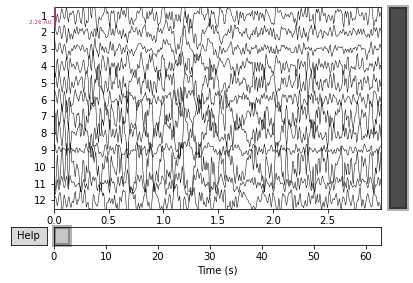

In [26]:
# extract feature from 12-channel source signal
data = train_data_encoded[0]
info = mne.create_info(ch_names= ['1','2','3','4','5','6','7','8','9','10','11','12',], sfreq=128)
raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None)
raw.plot(duration=3, n_channels=12);

Effective window size : 1.000 (s)
(12, 61, 125) (61,)


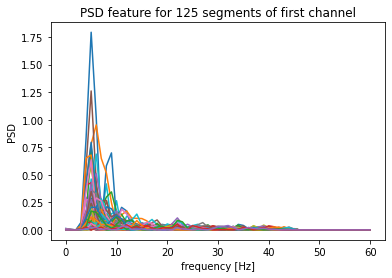

In [27]:
# calculate PSD of all channels using welch method
psd_origin, f = mne.time_frequency.psd_welch(raw, fmin=0, fmax=60, n_fft=128, n_overlap=64, n_per_seg=128, picks='all', window='hann', average=None, verbose=None)# average='mean' or None
print(psd_origin.shape, f.shape) # (12, 61, 125) (61,)
plt.plot(f, psd_origin[0]) # first channel psd of 125 segments
plt.title("PSD feature for 125 segments of first channel")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [31]:
trial_psd_extraction_integration(train_data_encoded[0])

Creating RawArray with float64 data, n_channels=12, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Effective window size : 1.000 (s)


array([[0.13124351, 0.03212402, 0.01606826, ..., 0.71497527, 0.12136183,
        0.13434794],
       [0.2174466 , 0.69900279, 0.6117928 , ..., 0.44712966, 0.11799444,
        0.07311185],
       [0.09166505, 0.43796157, 0.22409573, ..., 0.67975897, 0.09281551,
        0.16688083],
       ...,
       [0.39410687, 0.82625994, 0.41265292, ..., 0.5509756 , 0.04580255,
        0.20540557],
       [0.04157976, 0.0395835 , 0.0548331 , ..., 0.86153072, 0.08296881,
        0.12218433],
       [0.04975448, 0.01594303, 0.01240051, ..., 0.83893253, 0.13867465,
        0.11605456]])

# Load one subject data to test 

In [47]:
mat = scipy.io.loadmat('../Data/DEAP/s01.mat')
data = mat['data'][:, 0:32, 3*128:] # only first 32 channels ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']

one_data = data[0]

# change to mne format # system used in DEAP 'biosemi32'
biosemi32 = mne.channels.make_standard_montage('biosemi32')
info = mne.create_info(ch_names=biosemi32.ch_names, ch_types='eeg', sfreq=128)
raw = mne.EvokedArray(one_data, info) # first trial evoked data

print(data.shape)
print(np.amax(data)) # max value
print(np.amin(data)) # min value

(40, 32, 7680)
126.13356159993128
-93.12451745086868


Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


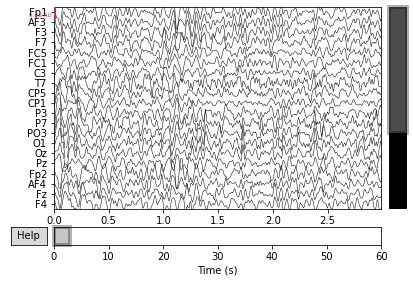

In [48]:
info_ = mne.create_info(ch_names= ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2'], sfreq=128)
raw_ = mne.io.RawArray(one_data, info_, first_samp=0, copy='auto', verbose=None);
raw_.plot(duration=3, n_channels=20);

# Visaulise electrodes position

Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


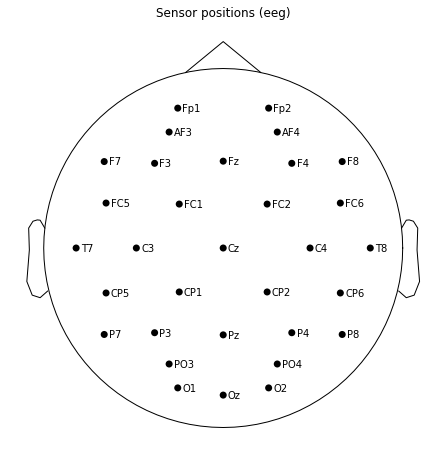

In [49]:
# fig = biosemi32.plot(kind='3d')
# fig.gca().view_init(azim=70, elev=15)
biosemi32.plot(kind='topomap', show_names=True);

# Visaulise colormap

(<matplotlib.image.AxesImage at 0x22845e52f28>,
 <matplotlib.contour.QuadContourSet at 0x22838b572b0>)

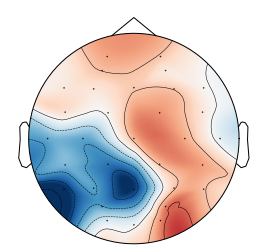

In [50]:
raw = raw.set_montage(biosemi32)
mne.viz.plot_topomap(raw.data[:, 0], raw.info, show=False) # time step 0

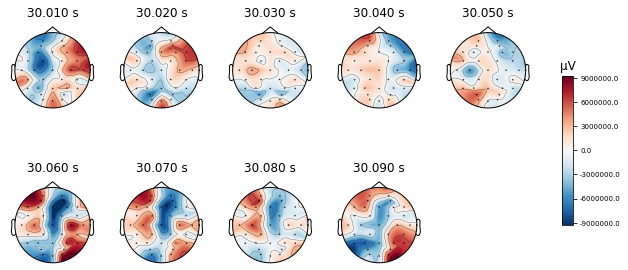

In [51]:
times = np.arange(30.01, 30.10, 0.01) # from 30s to 30.2s
raw.plot_topomap(times, ch_type='eeg', time_unit='s', ncols=5, nrows='auto');

# Compare original and standardized signal

In [53]:
standardised_data = standardise_2D(one_data, 1)

print(np.amax(one_data)) # max value
print(np.amin(one_data)) # min value
print(np.amax(standardised_data)) # max value
print(np.amin(standardised_data)) # min value

33.46697829071114
-31.335874596603272
8.3196132436574
-7.789838539676193


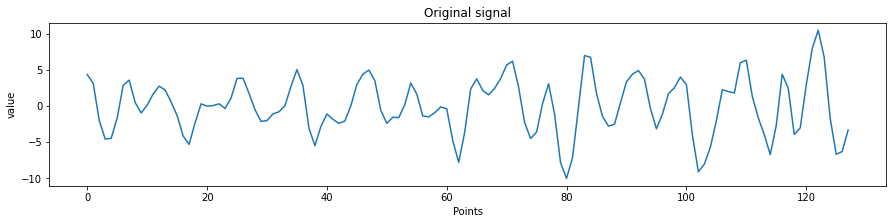

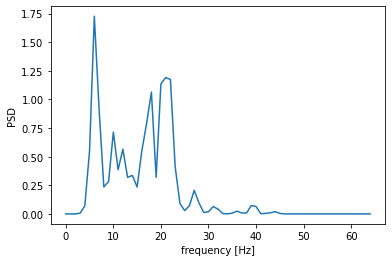

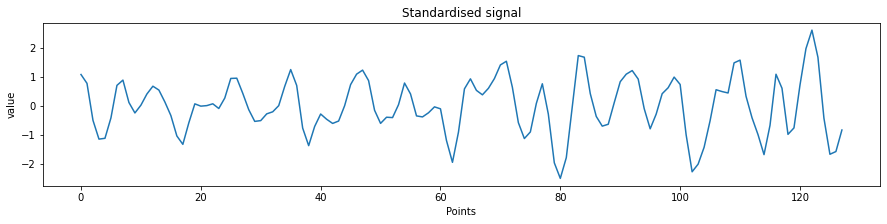

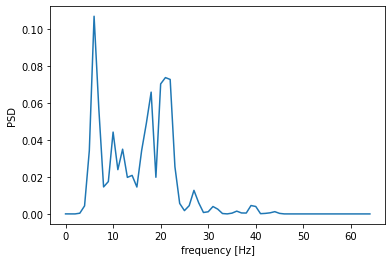

[ 43.90840737 105.68757443 213.48566124  64.13231123]


In [54]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(one_data[0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(one_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(standardised_data[0][nth*128:nth*128+128])
plt.title("Standardised signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(standardised_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

channel_psd, channel_psd2 = eeg_entropy.bin_power(standardised_data[0][nth*128:nth*128+128], [4,7.5,13.5,30.5,50], Fs=128)
print(channel_psd)

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


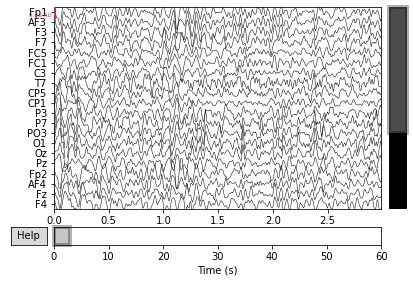

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


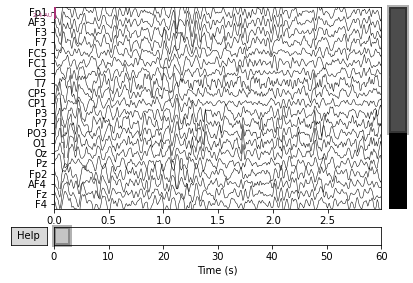

In [55]:
info2 = mne.create_info(ch_names= ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2'], sfreq=128)
raw2 = mne.io.RawArray(one_data, info2, first_samp=0, copy='auto', verbose=None);
raw2.plot(duration=3, n_channels=20);

stanardised_raw2 = mne.io.RawArray(standardised_data, info2, first_samp=0, copy='auto', verbose=None);
stanardised_raw2.plot(duration=3, n_channels=20);

# Compare original and normalised signal

In [56]:
def normalise_2D(a, multiple):
    max_, min_ = np.amax(a), np.amin(a)
    a = (a - min_) / (max_ - min_)
    return multiple*a

normalised_data = normalise_2D(one_data, 1)

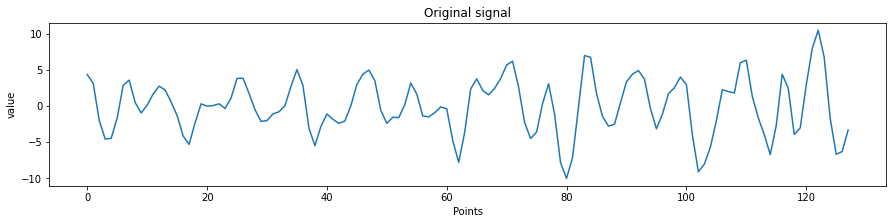

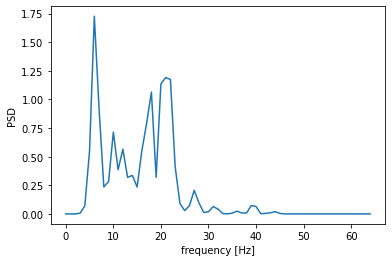

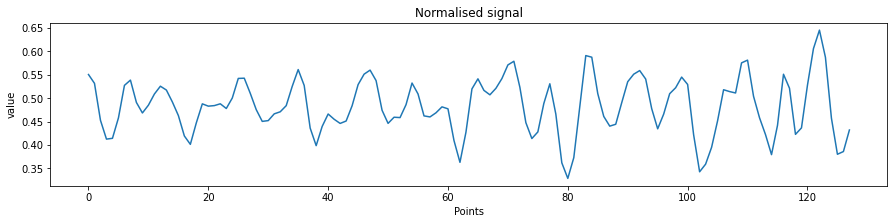

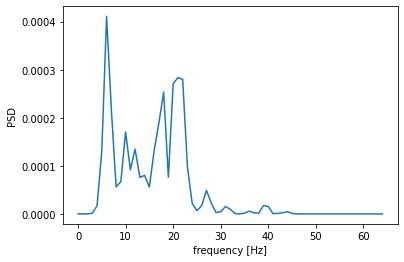

In [57]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(one_data[0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(one_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(normalised_data[0][nth*128:nth*128+128])
plt.title("Normalised signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(normalised_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


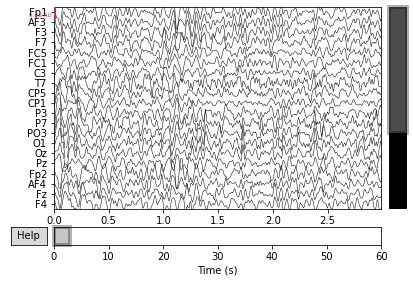

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


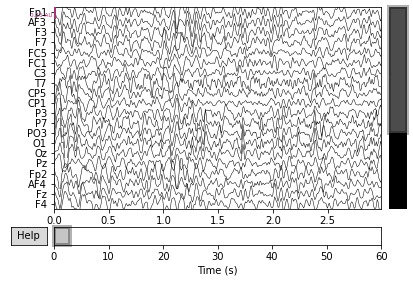

In [58]:
raw3 = mne.io.RawArray(one_data, info2, first_samp=0, copy='auto', verbose=None);
raw3.plot(duration=3, n_channels=20);

normalised_raw3 = mne.io.RawArray(normalised_data, info2, first_samp=0, copy='auto', verbose=None);
normalised_raw3.plot(duration=3, n_channels=20);

# Compare original signal and reconstructed signal

In [59]:
autoencoder = keras.models.load_model("../Results/autoencoder_model/autoencoder_model_test_fold_1")

In [60]:
temp = data[:2] # first two trial
data_ = []
for t in temp:
    data_.append(standardise_2D(t, 1))
print(np.amax(data_[0])) # max value
print(np.amin(data_[0])) # min value

8.3196132436574
-7.789838539676193


In [61]:
data_ = np.array(data_)
data_vector = vector_transform(data_)
print(data_vector.shape)
data_reconstructed_vector = autoencoder.predict(data_vector)
data_reconstructed = inverse_vector_transform(data_reconstructed_vector) 
data_reconstructed.shape

(15360, 32)


(2, 32, 7680)

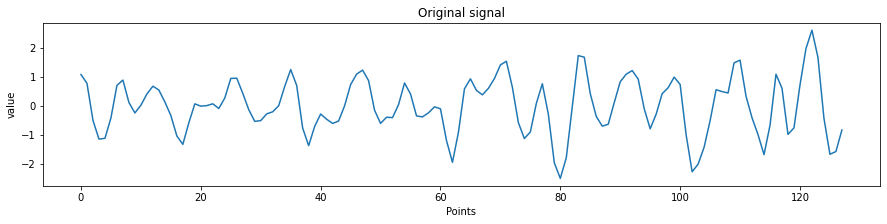

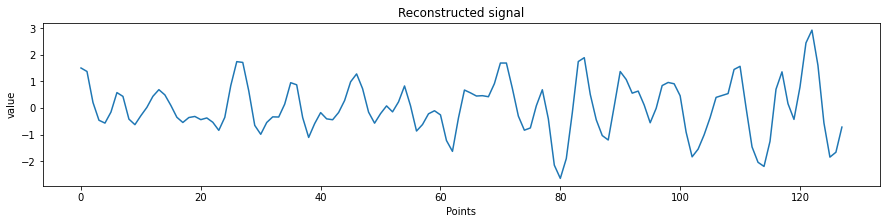

In [63]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(data_[0][0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(data_reconstructed[0][0][nth*128:nth*128+128])
plt.title("Reconstructed signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()